In [469]:
#!g1.1

import torch
from torch import nn
import numpy as np
import re
import random
import tqdm
import time
import torch.utils.data as data
from collections import defaultdict
import matplotlib.pyplot as plt

from IPython.display import clear_output

In [470]:
#!g1.1
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Предсказание детерминированной последовательности

Сгенерируем последовательности из цифр (от 0 до 9):
y1 = x1, y(i) = x(i) + x(1). Если y(i) >= 10, то y(i) = y(i) - 10

Научим модель предсказывать y(i) по x(i), сравним RNN, LSTM, GRU

In [471]:
#!g1.1
# Объявим функцию для генерации тензоров заданной длины

def generate_sample(length):
    X_sample = []
    y_sample = []
    for i in range(length):
        rand_num = random.randint(0, 9)
        X_sample.append(rand_num)
        if i == 0:
            y_sample.append(rand_num)
        else:
            y_sample.append((rand_num + y_sample[0]) % 10)
    return X_sample, y_sample
    

def generate_train_data(length, number):
    X_data = []
    y_data = []
    for i in range(number):
        X_sample, y_sample = generate_sample(length)
        X_data.append(X_sample)
        y_data.append(y_sample)
    return X_data, y_data

In [477]:
#!g1.1
# Объявим функцию для отображения кривых обучения

def plot_learning_curves(history):
    fig = plt.figure(figsize=(20, 5))

    plt.subplot(1,3,1)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.ylabel('loss', fontsize=15)
    plt.xlabel('epoch', fontsize=15)
    plt.grid()
    plt.legend()

    plt.subplot(1,3,2)
    plt.plot(history['acc']['train'], label='train')
    plt.plot(history['acc']['val'], label='val')
    plt.ylabel('accuracy', fontsize=15)
    plt.xlabel('epoch', fontsize=15)
    plt.grid()
    plt.legend()
    
    if bool(history['lr']):
        plt.subplot(1,3,3)
        for scheduler_name in history['lr']:
            plt.plot(history['lr'][scheduler_name], label=scheduler_name)
        plt.ylabel('lr', fontsize=15)
        plt.xlabel('epoch', fontsize=15)
        plt.grid()
        plt.legend()
    
    plt.show()


# Объявим функцию для обучения

def train(
    model,
    criterion,
    optimizer,
    schedulers,
    train_batch_gen,
    val_batch_gen,
    num_epochs=10
):
    # История значений точности модели и функции потерь
    history = defaultdict(lambda: defaultdict(list))
    alphabet_length = model.output.out_features

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        start_time = time.time()

        # Устанавливаем поведение dropout / batch_norm в режим обучение
        model.train(True)

        # На каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device).flatten()

            logits = model(X_batch).view(-1, alphabet_length)
    
            loss = criterion(logits, y_batch.long().to(device))

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)
            
            # Применяем LR Schedulers в конце шага
            for scheduler in schedulers.get("batch", []):
                scheduler.step()
        
        # Применяем LR Schedulers в конце эпохи
        for scheduler in schedulers.get("epoch", []):
            scheduler.step()

        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen)
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)
        
        for scheduler in schedulers.get("epoch", []):
            history['lr'][scheduler.__class__.__name__].append(scheduler.get_last_lr())
        for scheduler in schedulers.get("batch", []):
            history['lr'][scheduler.__class__.__name__].append(scheduler.get_last_lr())

        # Устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False)

        # Полностью проходим по валидационному датасету
        for X_batch, y_batch in val_batch_gen:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device).flatten()

            logits = model(X_batch).view(-1, alphabet_length)
            loss = criterion(logits, y_batch.long().to(device))
            val_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen)
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)

        clear_output()

        # Печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))

        plot_learning_curves(history)

    return model, history

In [487]:
#!g1.1
# Обучаем модели одинаковым образом
BATCH_SIZE=128
NUM_SAMPLES = 5000

In [488]:
#!g1.1
# Объявим функция для генерации обучающих выборок заданной длины

def get_train_val_loaders(lenght):
    X_data, y_data = generate_train_data(lenght, NUM_SAMPLES)

    X = torch.tensor(X_data).to(device)
    y = torch.tensor(y_data).to(device)
    
    dataset = torch.utils.data.TensorDataset(X, y)

    train_size = int(0.9 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = data.random_split(dataset, [train_size, val_size])

    train_gen = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_gen = data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    return train_gen, val_gen

In [489]:
#!g1.1
# Объявим конструктор модели

class NeuralNetwork(nn.Module):
    def __init__(self, rnnClass, dictionary_size, embedding_size, num_hiddens, num_classes):
        super().__init__()
        
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(dictionary_size, embedding_size)
        self.hidden = rnnClass(embedding_size, num_hiddens, batch_first=True)
        self.output = nn.Linear(num_hiddens, num_classes)
        
    def forward(self, X):
        out = self.embedding(X)
        rnn_out, state = self.hidden(out)
        predictions = self.output(rnn_out)
        return predictions

Epoch 100 of 100 took 0.167s
  training loss (in-iteration): 	0.002416
  validation loss (in-iteration): 	0.002422
  training accuracy: 			100.00 %
  validation accuracy: 			100.00 %


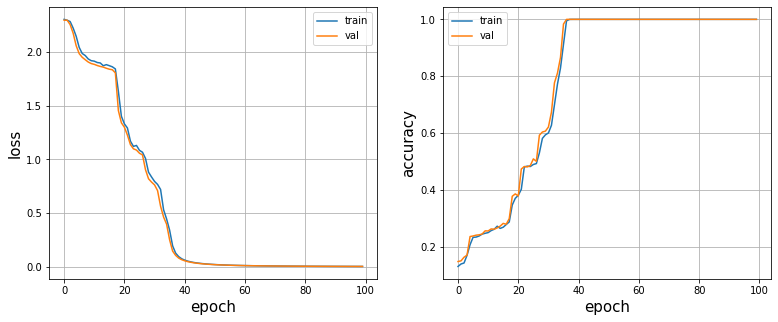

In [491]:
#!g1.1
# Длина 25, RNN

train_gen, val_gen = get_train_val_loaders(25)
model = NeuralNetwork(nn.RNN, 10, 64, 128, 10).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

_, rnn_25 = train(model, criterion, optimizer, {}, train_gen, val_gen, 100)

Epoch 100 of 100 took 0.181s
  training loss (in-iteration): 	0.919557
  validation loss (in-iteration): 	0.922061
  training accuracy: 			42.88 %
  validation accuracy: 			43.66 %


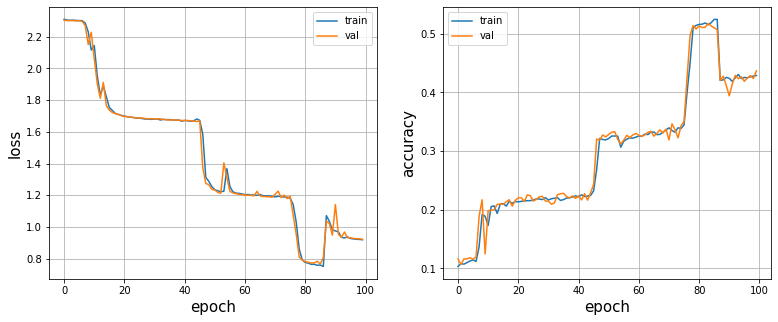

In [498]:
#!g1.1
# Длина 75, RNN

train_gen, val_gen = get_train_val_loaders(75)
model = NeuralNetwork(nn.RNN, 10, 64, 128, 10).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

_, rnn_75 = train(model, criterion, optimizer, {}, train_gen, val_gen, 100)

Epoch 100 of 100 took 0.186s
  training loss (in-iteration): 	0.797036
  validation loss (in-iteration): 	0.808058
  training accuracy: 			51.06 %
  validation accuracy: 			50.66 %


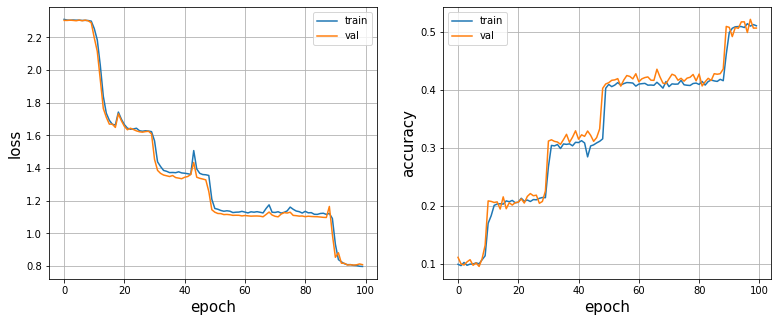

In [497]:
#!g1.1
# Длина 125, RNN

train_gen, val_gen = get_train_val_loaders(125)
model = NeuralNetwork(nn.RNN, 10, 64, 128, 10).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

_, rnn_125 = train(model, criterion, optimizer, {}, train_gen, val_gen, 100)

Epoch 100 of 100 took 0.166s
  training loss (in-iteration): 	0.000195
  validation loss (in-iteration): 	0.000205
  training accuracy: 			100.00 %
  validation accuracy: 			100.00 %


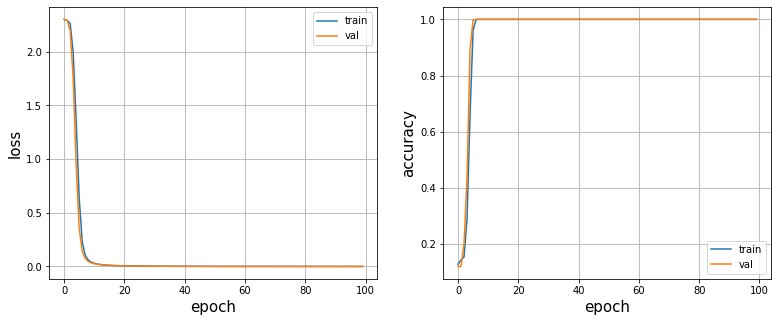

In [499]:
#!g1.1
# Длина 25, LSTM

train_gen, val_gen = get_train_val_loaders(25)
model = NeuralNetwork(nn.LSTM, 10, 64, 128, 10).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

_, lstm_25 = train(model, criterion, optimizer, {}, train_gen, val_gen, 100)

Epoch 100 of 100 took 0.198s
  training loss (in-iteration): 	0.000351
  validation loss (in-iteration): 	0.000349
  training accuracy: 			100.00 %
  validation accuracy: 			100.00 %


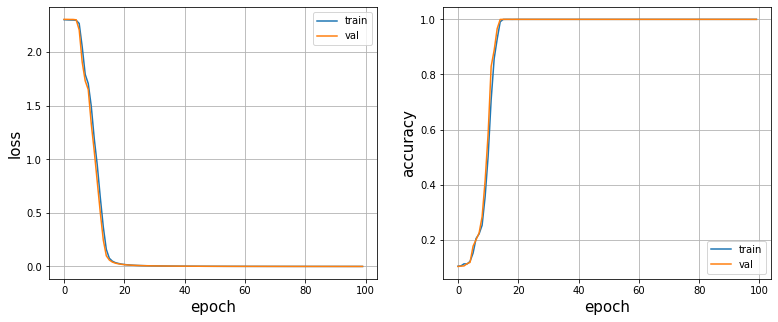

In [500]:
#!g1.1
# Длина 75, LSTM

train_gen, val_gen = get_train_val_loaders(75)
model = NeuralNetwork(nn.LSTM, 10, 64, 128, 10).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

_, lstm_75 = train(model, criterion, optimizer, {}, train_gen, val_gen, 100)

Epoch 100 of 100 took 0.245s
  training loss (in-iteration): 	0.000232
  validation loss (in-iteration): 	0.000231
  training accuracy: 			100.00 %
  validation accuracy: 			100.00 %


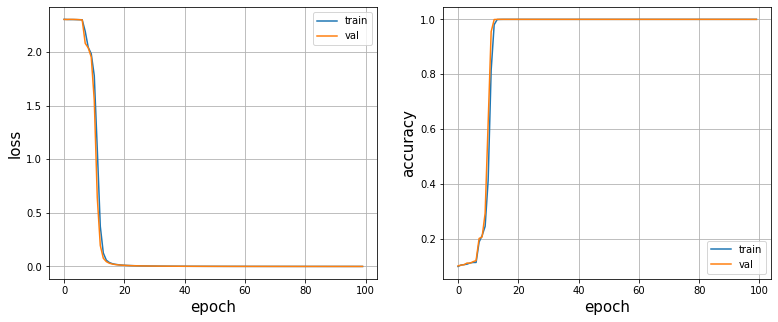

In [501]:
#!g1.1
# Длина 125, LSTM

train_gen, val_gen = get_train_val_loaders(125)
model = NeuralNetwork(nn.LSTM, 10, 64, 128, 10).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

_, lstm_125 = train(model, criterion, optimizer, {}, train_gen, val_gen, 100)

Epoch 100 of 100 took 0.167s
  training loss (in-iteration): 	0.000219
  validation loss (in-iteration): 	0.000219
  training accuracy: 			100.00 %
  validation accuracy: 			100.00 %


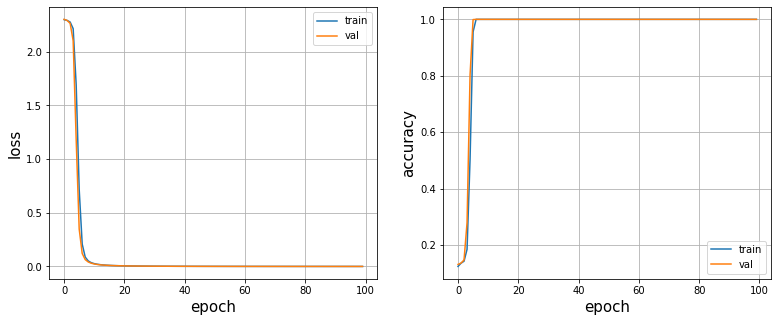

In [502]:
#!g1.1
# Длина 25, GRU

train_gen, val_gen = get_train_val_loaders(25)
model = NeuralNetwork(nn.GRU, 10, 64, 128, 10).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

_, gru_25 = train(model, criterion, optimizer, {}, train_gen, val_gen, 100)

Epoch 100 of 100 took 0.186s
  training loss (in-iteration): 	0.000294
  validation loss (in-iteration): 	0.000294
  training accuracy: 			100.00 %
  validation accuracy: 			100.00 %


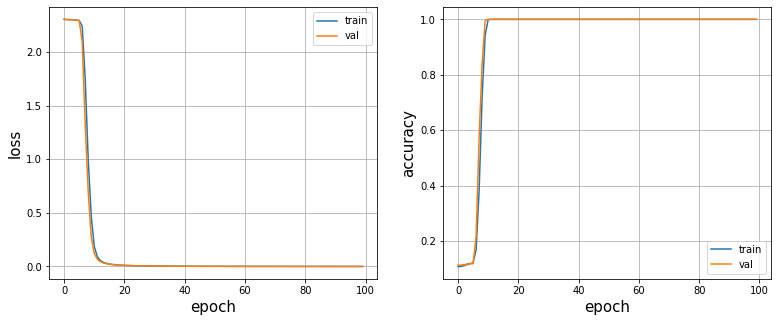

In [503]:
#!g1.1
# Длина 75, GRU

train_gen, val_gen = get_train_val_loaders(75)
model = NeuralNetwork(nn.GRU, 10, 64, 128, 10).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

_, gru_75 = train(model, criterion, optimizer, {}, train_gen, val_gen, 100)

Epoch 100 of 100 took 0.204s
  training loss (in-iteration): 	0.000417
  validation loss (in-iteration): 	0.000421
  training accuracy: 			100.00 %
  validation accuracy: 			100.00 %


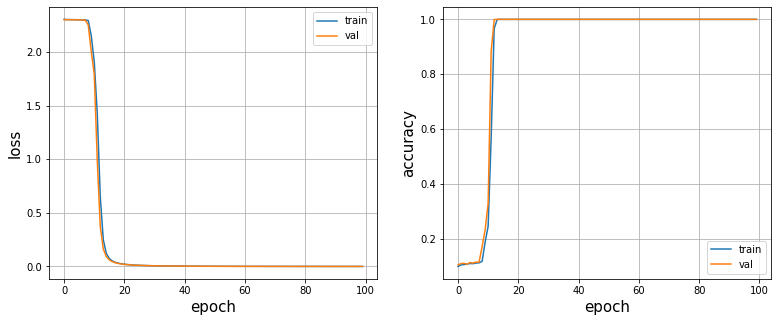

In [504]:
#!g1.1
# Длина 125, GRU

train_gen, val_gen = get_train_val_loaders(125)
model = NeuralNetwork(nn.GRU, 10, 64, 128, 10).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

_, gru_125 = train(model, criterion, optimizer, {}, train_gen, val_gen, 100)

Теперь сведем графики вместе для наглядности

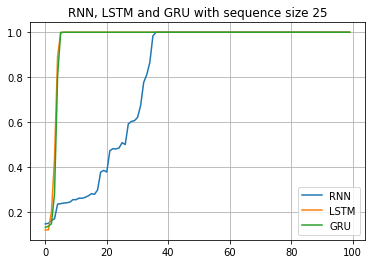

In [510]:
#!g1.1
plt.plot(rnn_25['acc']['val'], label='RNN')
plt.plot(lstm_25['acc']['val'], label='LSTM')
plt.plot(gru_25['acc']['val'], label='GRU')
plt.grid()
plt.legend()
plt.title('RNN, LSTM and GRU with sequence size 25')
plt.show()

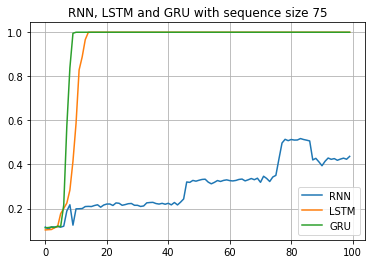

In [511]:
#!g1.1
plt.plot(rnn_75['acc']['val'], label='RNN')
plt.plot(lstm_75['acc']['val'], label='LSTM')
plt.plot(gru_75['acc']['val'], label='GRU')
plt.grid()
plt.legend()
plt.title('RNN, LSTM and GRU with sequence size 75')
plt.show()

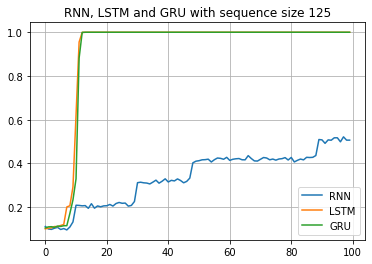

In [512]:
#!g1.1
plt.plot(rnn_125['acc']['val'], label='RNN')
plt.plot(lstm_125['acc']['val'], label='LSTM')
plt.plot(gru_125['acc']['val'], label='GRU')
plt.grid()
plt.legend()
plt.title('RNN, LSTM and GRU with sequence size 125')
plt.show()

## Итого

У RNN есть проблема "исчезающего градиента", когда градиент становится слишком маленьким при обратном распространении ошибки на длинных последовательностях, что затрудняет обучение на таких данных. Для выбранной архитектуры сети достигнуть успешного результата за 100 эпох удалось только для самой короткой последовательности

LSTM решает проблему исчезающего градиента. Она имеет дополнительные блоки памяти, которые могут сохранять информацию на длинных последовательностях и контролировать поток информации внутри сети (подкреплять и удалять информацию). Выбранная конфигурация решает задачу даже для самой длинной последовательности за 15 эпох.

GRU также решает проблему исчезающего градиента и способна запоминать длинные последовательности. Численные результаты в среднем аналогичны LSTM в данной задаче.

В целом, LSTM и GRU способны лучше запоминать длинные последовательности, чем обычные RNN. Однако, GRU имеет меньше параметров, чем LSTM и может работать быстрее на некоторых задачах.

In [ ]:
#!g1.1
